# Sea Ica Classification with Unsupervised Learning

## Imports

In [ ]:
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np
import rasterio
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

## Read and Preprocess Data

### S2A Images
Sentinel-2 optical data

In [2]:
s2a_base_path = "./S2A_IMG_DATA/"
bands_paths = {
    'B1': s2a_base_path + 'T01WCU_20190301T235611_B01.jp2',
    'B2': s2a_base_path + 'T01WCU_20190301T235611_B02.jp2',
    'B3': s2a_base_path + 'T01WCU_20190301T235611_B03.jp2',
    'B4': s2a_base_path + 'T01WCU_20190301T235611_B04.jp2',
    'B5': s2a_base_path + 'T01WCU_20190301T235611_B05.jp2',
    'B6': s2a_base_path + 'T01WCU_20190301T235611_B06.jp2',
    'B7': s2a_base_path + 'T01WCU_20190301T235611_B07.jp2',
    'B8': s2a_base_path + 'T01WCU_20190301T235611_B08.jp2',
    'B9': s2a_base_path + 'T01WCU_20190301T235611_B09.jp2',
    'B10': s2a_base_path + 'T01WCU_20190301T235611_B10.jp2',
    'B11': s2a_base_path + 'T01WCU_20190301T235611_B11.jp2',
    'B12': s2a_base_path + 'T01WCU_20190301T235611_B12.jp2'
}

#### Band 9
Read and create a dataset of the ninth band.

In [3]:
for band in ['B9']:
    band_data_S2_B9 = []
    with rasterio.open(bands_paths[band]) as src:
        band_data_S2_B9.append(src.read(1))

    # Stack bands and create a mask for valid data (non-zero values in all bands)
    band_stack_S2_B9 = np.dstack(band_data_S2_B9)
    # Create a mask for valid data (non-zero values in all bands of the same shape)
    valid_data_mask_S2_B9 = np.all(band_stack_S2_B9 > 0, axis=2)
    X_S2_B9 = band_stack_S2_B9[valid_data_mask_S2_B9].reshape((-1, 1))


#### Combine bands
Read and combine the band that have the same dimensions. This enables the clustering algirithms to identify similarities in multiple dimensions, each dimension corresponding to a band.

In [4]:
# Read and stack the band images
band_data_S2_dict = {}
X_S2_dict = {}
valid_data_mask_dict = {}

for band in bands_paths.keys():
    band_data_S2 = []
    with rasterio.open(bands_paths[band]) as src:
        band_data_S2.append(src.read(1))

    # Stack bands and create a mask for valid data (non-zero values in all bands)
    band_stack_S2 = np.dstack(band_data_S2)
    band_data_S2_dict[band] = band_stack_S2

# Create dictionaries to store bands with the same shape
same_shape_bands = {}
# Iterate through the bands and group them by shape
for key, val in band_data_S2_dict.items():
    shape = val.shape
    if shape not in same_shape_bands:
        same_shape_bands[shape] = []
    same_shape_bands[shape].append(key)

# Print the dictionaries
for shape, bands in same_shape_bands.items():
    print(f"Shape: {shape}, Bands: {bands}")

    # Create a mask for valid data (non-zero values in all bands of the same shape)
    valid_data_mask = np.all(np.dstack([band_data_S2_dict[band] for band in bands]) > 0, axis=2)
    valid_data_mask_dict[shape] = valid_data_mask
    
    for band in bands:
        # Reshape for K-means, only including valid data
        X_S2 = band_data_S2_dict[band][valid_data_mask].reshape((-1, 1))
        X_S2_dict[band] = X_S2


Shape: (1830, 1830, 1), Bands: ['B1', 'B9', 'B10']
Shape: (10980, 10980, 1), Bands: ['B2', 'B3', 'B4', 'B8']
Shape: (5490, 5490, 1), Bands: ['B5', 'B6', 'B7', 'B11', 'B12']


#### Visualize images based on 12 different bands

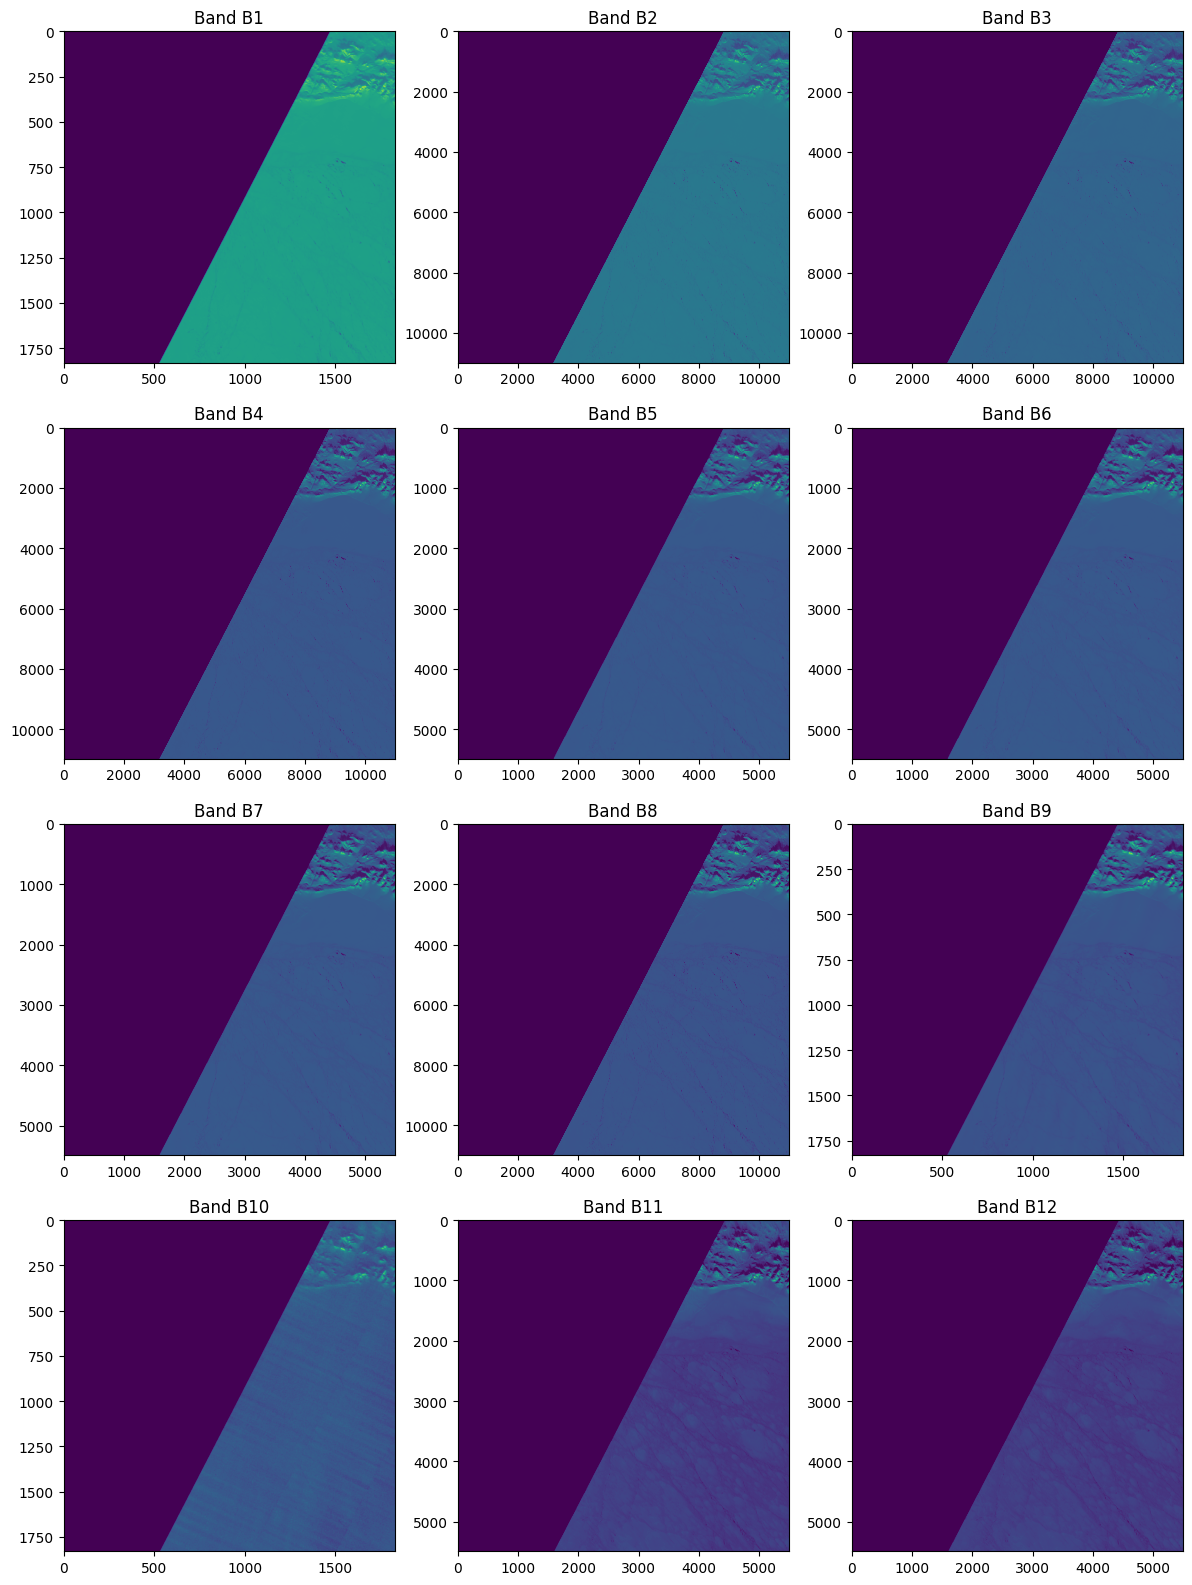

In [5]:
fig, axs = plt.subplots(4, 3, figsize=(12, 16))

bands = list(band_data_S2_dict.keys())
for i, band in enumerate(bands):
    ax = axs[i//3, i%3]
    ax.imshow(band_data_S2_dict[band][:,:,0])
    ax.set_title(f"Band {band}")

plt.tight_layout()
plt.show()

### S3A Images
Read sentinel-3 altimetry data and extract relevant metrics such as pulse peakiness and stack standard deviation and amplitude.

#### Pre-processing functions

In [6]:
def by_row(waves, *args):
    "calculate peakiness for each waveform"
    maximum=np.nanmax(waves)
    if maximum > 0:

        maximum_bin=np.where(waves==maximum)
        #print(maximum_bin)
        maximum_bin=maximum_bin[0][0]
        waves_128=waves[maximum_bin-50:maximum_bin+78]

        waves=waves_128

        noise_floor=np.nanmean(waves[10:20])
        where_above_nf=np.where(waves > noise_floor)

        if np.shape(where_above_nf)[1] > 0:
            maximum=np.nanmax(waves[where_above_nf])
            total=np.sum(waves[where_above_nf])
            mean=np.nanmean(waves[where_above_nf])
            peaky=maximum/mean

        else:
            peaky = np.nan
            maximum = np.nan
            total = np.nan

    else:
        peaky = np.nan
        maximum = np.nan
        total = np.nan

    if 'maxs' in args:
        return maximum
    if 'totals' in args:
        return total
    if 'peaky' in args:
        return peaky

def plot_waveforms(waves1, maximums, totals, peaky, size, i):
    plt.plot(waves1[i,:])#, a, col[i],label=label[i])
    plt.axhline(maximums[i], color='green')
    plt.axvline(10, color='r')
    plt.axvline(19, color='r')
    plt.xlabel('Bin (of 256)')
    plt.ylabel('Power')
    plt.text(5,maximums[i],"maximum="+str(maximums[i]))
    plt.text(5,maximums[i]-2500,"total="+str(totals[i]))
    plt.text(5,maximums[i]-5000,"peakiness="+str(peaky[i]))
    plt.title('waveform '+str(i)+' of '+str(size)+'\n. Noise floor average taken between red lines.')
    plt.show()

def peakiness(waves, **kwargs):
    # Finds peakiness of waveforms
    print("Running peakiness function...")
    size=np.shape(waves)[0] #.shape property is a tuple of length .ndim containing the length of each dimensions
                            #Tuple of array dimensions.
    waves1=np.copy(waves)
    if waves1.ndim == 1: #number of array dimensions
        print('only one waveform in file')
        waves2=waves1.reshape(1,np.size(waves1)) #numpy.reshape(a, newshape, order='C'), a=array to be reshaped
        waves1=waves2
    
    peaky=np.apply_along_axis(by_row, 1, waves1, 'peaky') #numpy.apply_along_axis(func1d, axis, arr, *args, **kwargs)
    if 'wf_plots' in kwargs:
        maximums=np.apply_along_axis(by_row, 1, waves1, 'maxs')
        totals=np.apply_along_axis(by_row, 1, waves1, 'totals')
        for i in range(0,kwargs['wf_plots']):
            if i == 0:
                print("Plotting first "+str(kwargs['wf_plots'])+" waveforms")
            plot_waveforms(waves1, maximums, totals, peaky, size, i)
            
    return peaky


def unpack_gpod(variable, SAR_data):
    time_1hz=SAR_data.variables['time_01'][:]
    time_20hz=SAR_data.variables['time_20_ku'][:]
    time_20hzC = SAR_data.variables['time_20_c'][:]

    out=(SAR_data.variables[variable][:]).astype(float)  # convert from integer array to float.

    #if ma.is_masked(dataset.variables[variable][:]) == True:
    #print(variable,'is masked. Removing mask and replacing masked values with nan')
    out=np.ma.filled(out, np.nan)
    if len(out)==len(time_1hz):
        print(variable,'is 1hz. Expanding to 20hz...')
        out = interp1d(time_1hz,out,fill_value="extrapolate")(time_20hz)
    if len(out)==len(time_20hzC):
        print(variable, 'is c band, expanding to 20hz ku band dimension')
        out = interp1d(time_20hzC,out,fill_value="extrapolate")(time_20hz)
    return out

def gaussian(x,a,x0,sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

def calculate_SSD(RIP):
    do_plot='Off'
    SSD=np.zeros(np.shape(RIP)[0])*np.nan
    x=np.arange(np.shape(RIP)[1])

    for i in range(np.shape(RIP)[0]):
        y=np.copy(RIP[i])
        y[(np.isnan(y)==True)]=0

        if 'popt' in locals():
            del(popt,pcov)

        SSD_calc=0.5*(np.sum(y**2)*np.sum(y**2)/np.sum(y**4))
        #print('SSD calculated from equation',SSD)

        #n = len(x)
        mean_est = sum(x * y) / sum(y)
        sigma_est = np.sqrt(sum(y * (x - mean_est)**2) / sum(y))
        #print('est. mean',mean,'est. sigma',sigma_est)

        try:
            popt,pcov = curve_fit(gaussian, x, y, p0=[max(y), mean_est, sigma_est],maxfev=10000)
        except RuntimeError as e:
            print("Gaussian SSD curve-fit error: "+str(e))
            #plt.plot(y)
            #plt.show()

        except TypeError as t:
            print("Gaussian SSD curve-fit error: "+str(t))

        if do_plot=='ON':
            plt.plot(x,y)
            plt.plot(x,gaussian(x,*popt),'ro:',label='fit')
            plt.axvline(popt[1])
            plt.axvspan(popt[1]-popt[2], popt[1]+popt[2], alpha=0.15, color='Navy')
            plt.show()
            print('popt',popt)
            print('curve fit SSD',popt[2])

        if 'popt' in locals():
            SSD[i]=abs(popt[2])

    return SSD


#### Pre-processing

In [7]:
SAR_base_path = "./S3A_DATA/"
SAR_data = Dataset(SAR_base_path + '/enhanced_measurement.nc')

SAR_lat = unpack_gpod('lat_20_ku', SAR_data)
SAR_lon = unpack_gpod('lon_20_ku', SAR_data)
waves   = unpack_gpod('waveform_20_ku', SAR_data)
sig_0   = unpack_gpod('sig0_water_20_ku', SAR_data)
RIP     = unpack_gpod('rip_20_ku', SAR_data)
flag = unpack_gpod('surf_type_class_20_ku', SAR_data)

# Filter out bad data points using criteria (here, lat >= -99999)
find = np.where(SAR_lat >= -99999)
SAR_lat = SAR_lat[find]
SAR_lon = SAR_lon[find]
waves   = waves[find]
sig_0   = sig_0[find] # amplitude
RIP     = RIP[find] # range integrated power

# Calculate additional features
PP = peakiness(waves)
SSD = calculate_SSD(RIP)

# Convert to numpy arrays (if not already)
sig_0_np = np.array(sig_0)
PP_np    = np.array(PP) # peakiness
SSD_np   = np.array(SSD) # stack standard deviation

# Create data matrix
SAR_data = np.column_stack((sig_0_np, PP_np, SSD_np))

# Standardize the data
scaler = StandardScaler()
SAR_data_normalized = scaler.fit_transform(SAR_data)

# Remove any rows that contain NaN values
nan_count = np.isnan(SAR_data_normalized).sum()
print(f"Number of NaN values in the array: {nan_count}")

SAR_data_cleaned = SAR_data_normalized[~np.isnan(SAR_data_normalized).any(axis=1)]

SAR_mask = ~np.isnan(SAR_data_normalized).any(axis=1)
waves_cleaned = np.array(waves)[SAR_mask]
flag_cleaned = np.array(flag)[SAR_mask]

SAR_data_cleaned = SAR_data_cleaned[(flag_cleaned==1)|(flag_cleaned==2)]
waves_cleaned = waves_cleaned[(flag_cleaned==1)|(flag_cleaned==2)]
flag_cleaned = flag_cleaned[(flag_cleaned==1)|(flag_cleaned==2)]

Running peakiness function...


/var/folders/ct/xthzn_4x0yz795554nxnb4x00000gn/T/ipykernel_78335/2772702342.py:13: RuntimeWarning: Mean of empty slice
  noise_floor=np.nanmean(waves[10:20])


Gaussian SSD curve-fit error: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Gaussian SSD curve-fit error: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Gaussian SSD curve-fit error: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Number of NaN values in the array: 1283


#### Visualize altimetry data
The x-axis corresponds to the (very tiny) timesteps at which the echo is returned.

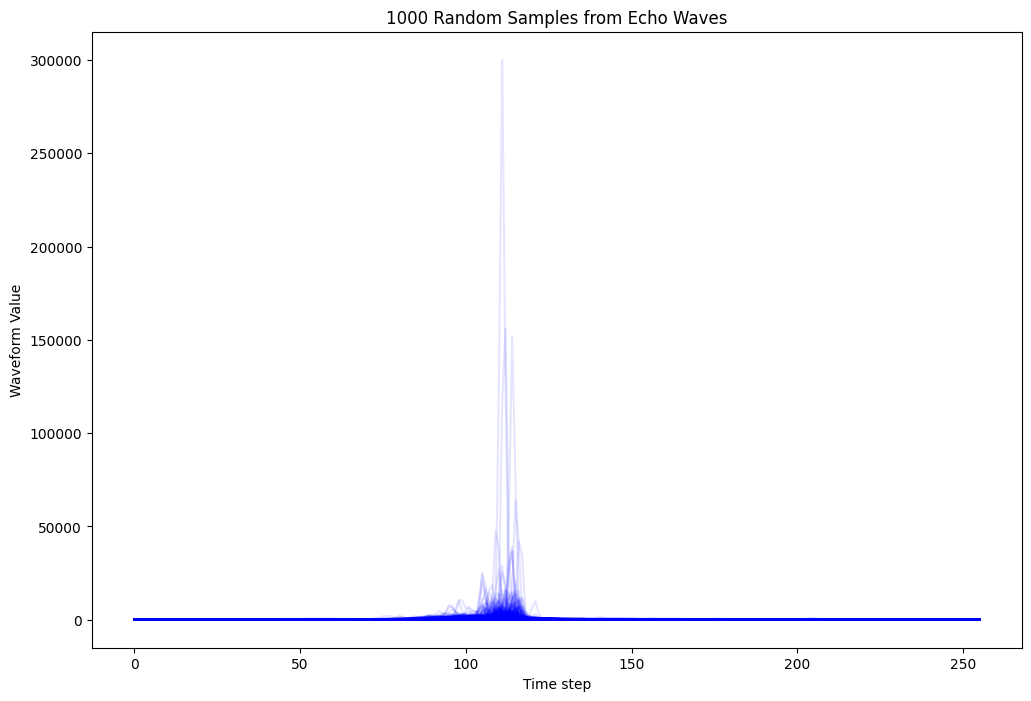

In [8]:
import random

plt.figure(figsize=(12, 8))
for i in random.sample(range(waves_cleaned.shape[0]), 1000):
    plt.plot(waves_cleaned[i], color='blue', alpha=0.1)
plt.title('1000 Random Samples from Echo Waves')
plt.xlabel('Time step')
plt.ylabel('Waveform Value')
plt.show()

## Cluster
This notebook explores the K-Means algorithm and Gaussian Mixture Models (GMMs). Although the aim is to identify sea ice and leads (2 classes), this notebook explores clustering with more than two clusters. This is of intresting because it might be easier for the model to, for instance, identify four classes which of three represent lead, than identify exactly one sea ice cluster and one lead cluster.

### K-Means: Satellite Images

#### Cluster band 9 with 2, 3, 4 and 5 clusters

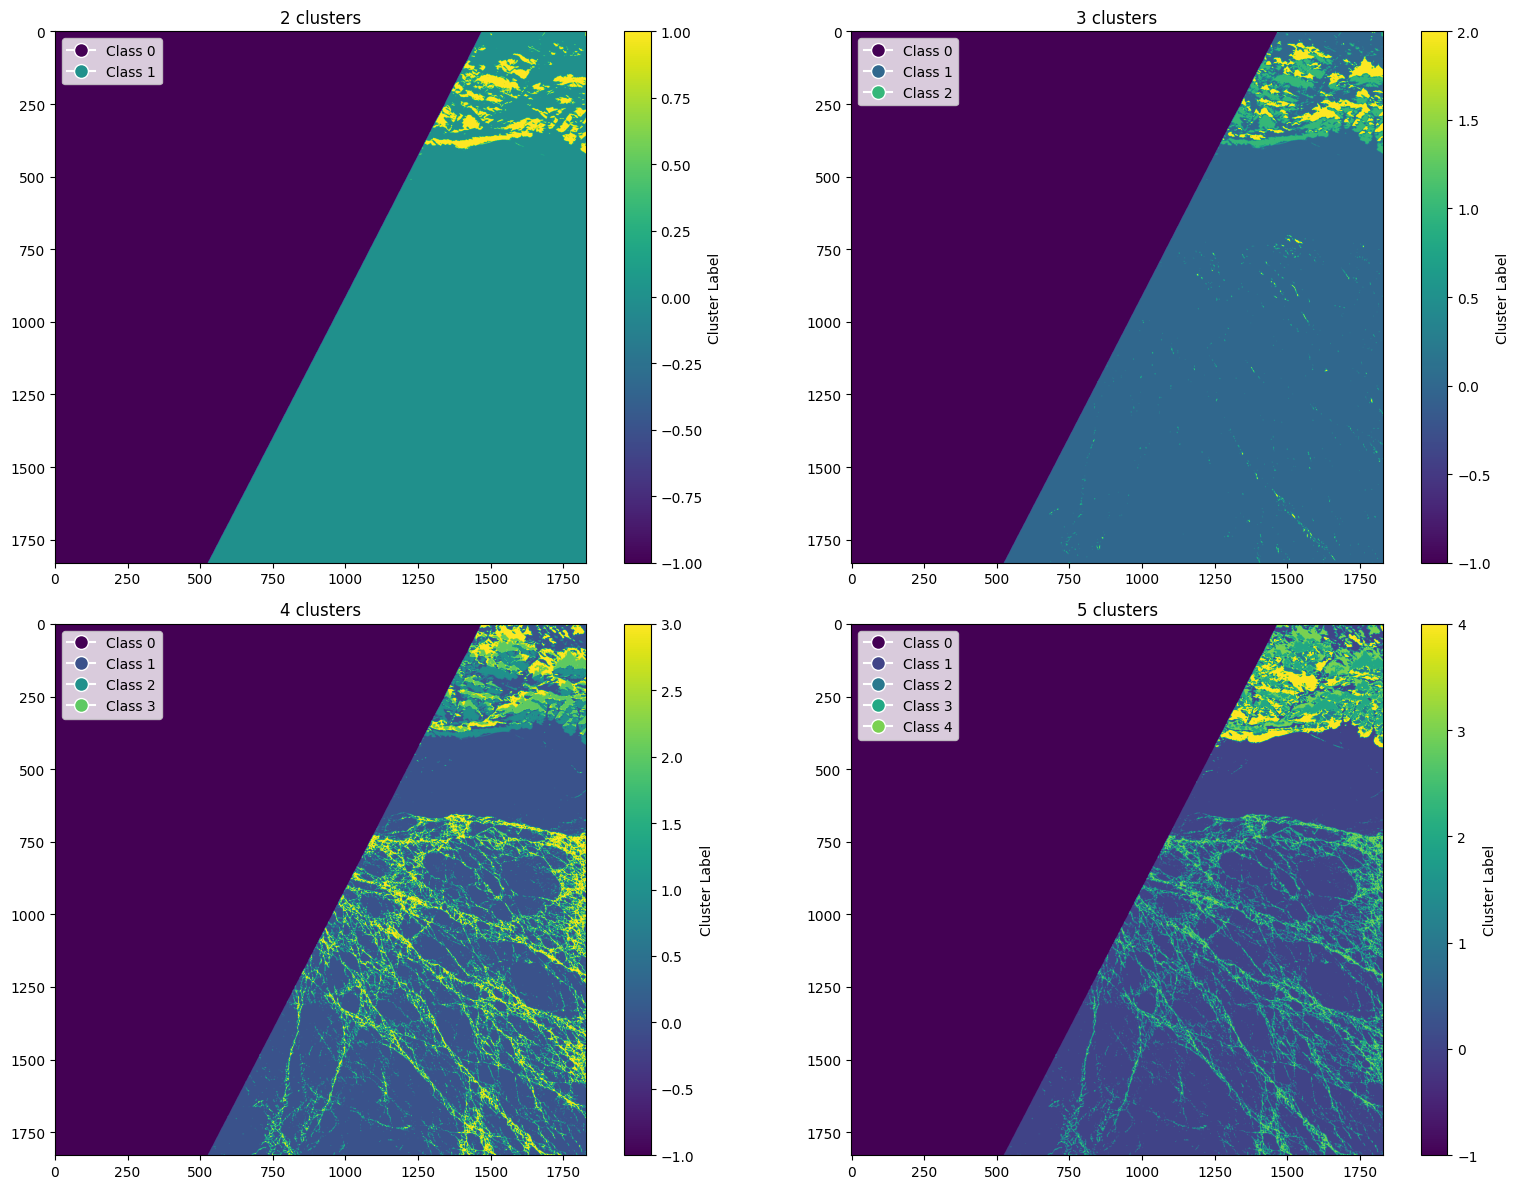

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

for k in range(0, 4):
# K-means clustering
    kmeans = KMeans(n_clusters=k+2, random_state=1, max_iter=10).fit(X_S2_B9)
    labels = kmeans.labels_
    labels_image = np.full(band_stack_S2_B9.shape[:2], -1, dtype=int)
    
    # Place cluster labels in the locations corresponding to valid data
    labels_image[valid_data_mask_S2_B9] = labels
    im = axs[k//2][k%2].imshow(labels_image, cmap='viridis')
    axs[k//2][k%2].set_title(f"{str(k+2)} clusters")
    fig.colorbar(im, orientation='vertical', label='Cluster Label')
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.viridis(i / (k+2)), markersize=10) for i in range(k+2)]
    labels = [f'Class {i}' for i in range(k+2)]
    axs[k//2][k%2].legend(handles, labels, loc='upper left')

plt.tight_layout()
plt.savefig("Results/KMeans_results.png")
plt.show()

#### Cluster different compitations of bands with 2, 3 and 4 clusters

Bands: B1,B9,B10
	2 clusters:
	3 clusters:
	4 clusters:
Bands: B2,B3,B4,B8
	2 clusters:
	3 clusters:
	4 clusters:
Bands: B5,B6,B7,B11,B12
	2 clusters:
	3 clusters:
	4 clusters:


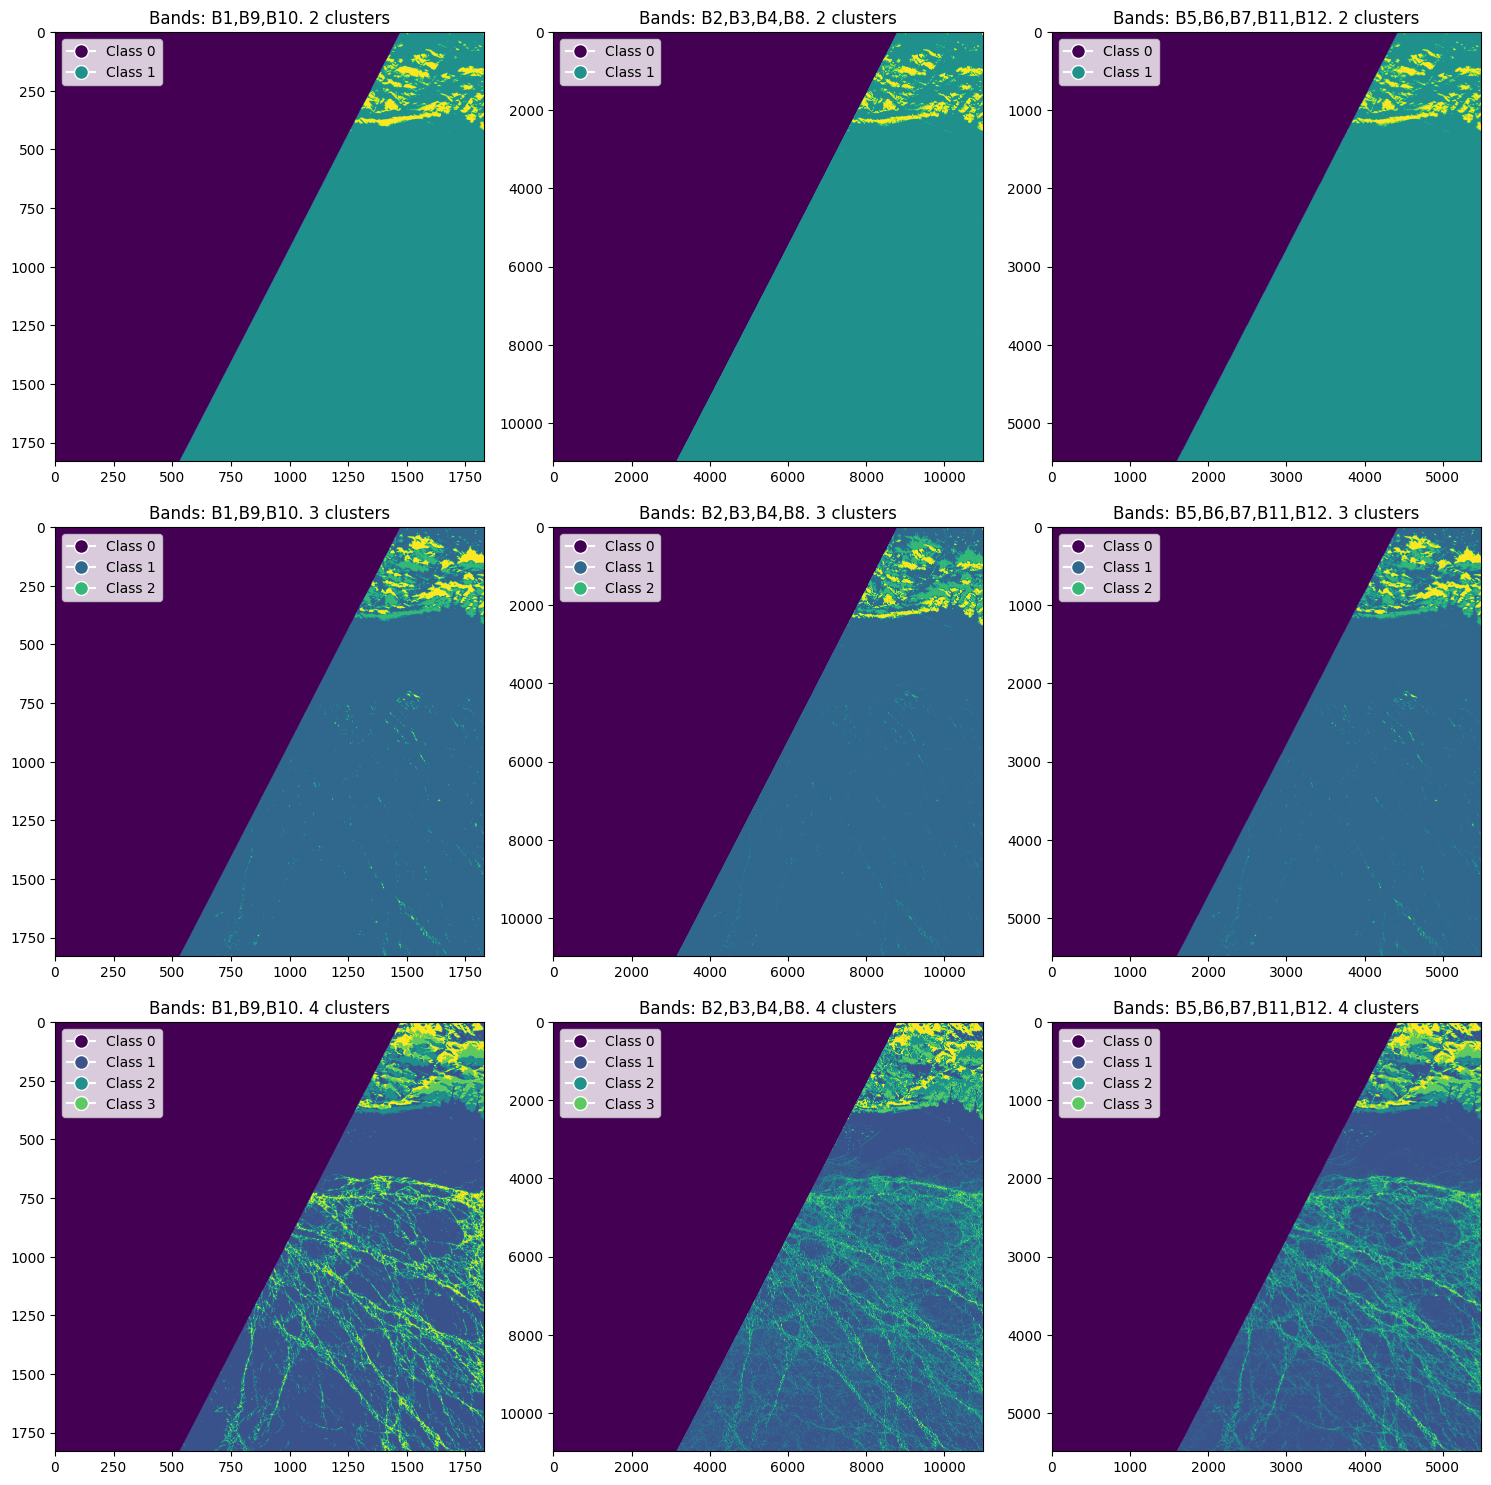

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

kmeans_class_counts_dict = {}
# K-means clustering
for row, (shape, bands_to_include) in enumerate(same_shape_bands.items()):
    print(f"Bands: {','.join(bands_to_include)}")
    class_counts_shape = {}
    X_S2_all = np.hstack([X_S2_dict[band] for band in bands_to_include])
    band_stack_S2 = np.dstack([band_data_S2_dict[band] for band in bands_to_include])
    valid_data_mask = valid_data_mask_dict[shape]
    labels_image = np.full(band_stack_S2.shape[:2], -1, dtype=int)
    for k in range(0, 3):
        print(f"\t{k+2} clusters:")
        class_counts_k = {}
        kmeans = KMeans(n_clusters=k+2, random_state=0, max_iter=10).fit(X_S2_all)
        labels = kmeans.labels_
        labels_image[valid_data_mask] = labels
        im = axs[k][row].imshow(labels_image, cmap='viridis')
        axs[k][row].set_title(f"Bands: {','.join(bands_to_include)}. {str(k+2)} clusters")
        # Create a legend for the classes
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.viridis(i / (k+2)), markersize=10) for i in range(k+2)]
        labels = [f'Class {i}' for i in range(k+2)]
        axs[k][row].legend(handles, labels, loc='upper left')

        unique, counts = np.unique(labels, return_counts=True)
        class_counts = dict(zip(unique, counts))
        for key, val in class_counts.items():
            class_counts_k[key] = val
        class_counts_shape[k] = class_counts_k
    kmeans_class_counts_dict[shape] = class_counts_shape

plt.tight_layout()
plt.savefig("Results/KMeans_combined_bands_results.png")
plt.show()

### GMM: Satellite Images

#### Cluster band 9 with 2, 3, 4 and 5 clusters


Cluster counts with 2 clusters:
	Cluster 0: 1310169
	Cluster 1: 211962


/opt/homebrew/Caskroom/miniforge/base/envs/GEOL0069-w4/lib/python3.9/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(



Cluster counts with 3 clusters:
	Cluster 0: 1313292
	Cluster 1: 114010
	Cluster 2: 94829


/opt/homebrew/Caskroom/miniforge/base/envs/GEOL0069-w4/lib/python3.9/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(



Cluster counts with 4 clusters:
	Cluster 0: 213680
	Cluster 1: 126934
	Cluster 2: 27007
	Cluster 3: 1154510


/opt/homebrew/Caskroom/miniforge/base/envs/GEOL0069-w4/lib/python3.9/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(



Cluster counts with 5 clusters:
	Cluster 0: 214603
	Cluster 1: 85643
	Cluster 2: 47752
	Cluster 3: 1154890
	Cluster 4: 19243


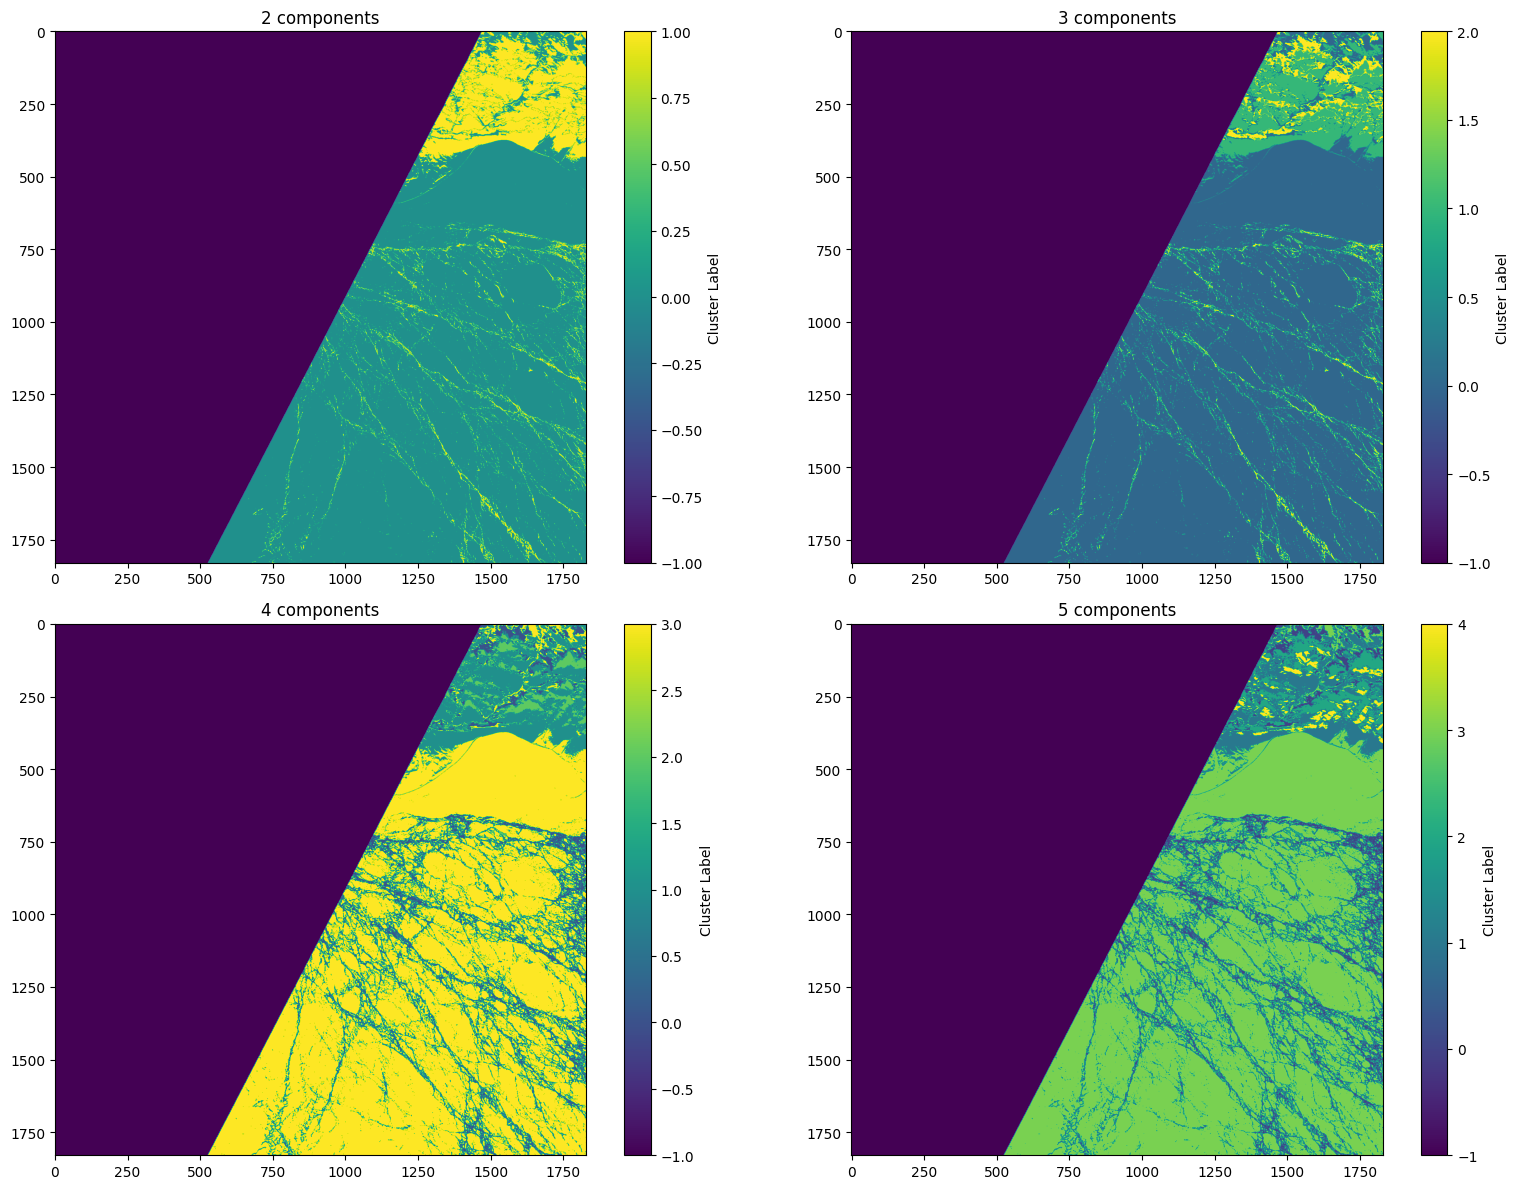

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

for n in range(0, 4):
    gmm = GaussianMixture(n_components=n+2, random_state=0, max_iter=10).fit(X_S2_B9)
    labels = gmm.predict(X_S2_B9)
    # Create an empty array for the result, filled with a no-data value (e.g., -1)
    labels_image = np.full(band_stack_S2_B9.shape[:2], -1, dtype=int)
    # Place cluster labels in the locations corresponding to valid data
    labels_image[valid_data_mask_S2_B9] = labels
    im = axs[n//2][n%2].imshow(labels_image, cmap='viridis')
    axs[n//2][n%2].set_title(f"{str(n+2)} components")
    fig.colorbar(im, orientation='vertical', label='Cluster Label')

    unique, counts = np.unique(labels, return_counts=True)
    class_counts = dict(zip(unique, counts))
    print(f"\nCluster counts with {n+2} clusters:")
    for key, val in class_counts.items():
        print(f"\tCluster {key}: {val}")

plt.tight_layout()
plt.savefig("Results/GMM_results.png")
plt.show()


#### Cluster different compitations of bands with 2, 3 and 4 clusters

Bands: B1,B9,B10
	2 clusters:
	3 clusters:
	4 clusters:


/opt/homebrew/Caskroom/miniforge/base/envs/GEOL0069-w4/lib/python3.9/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Bands: B2,B3,B4,B8
	2 clusters:


/opt/homebrew/Caskroom/miniforge/base/envs/GEOL0069-w4/lib/python3.9/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


	3 clusters:


/opt/homebrew/Caskroom/miniforge/base/envs/GEOL0069-w4/lib/python3.9/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


	4 clusters:


/opt/homebrew/Caskroom/miniforge/base/envs/GEOL0069-w4/lib/python3.9/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Bands: B5,B6,B7,B11,B12
	2 clusters:


/opt/homebrew/Caskroom/miniforge/base/envs/GEOL0069-w4/lib/python3.9/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


	3 clusters:


/opt/homebrew/Caskroom/miniforge/base/envs/GEOL0069-w4/lib/python3.9/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


	4 clusters:


/opt/homebrew/Caskroom/miniforge/base/envs/GEOL0069-w4/lib/python3.9/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


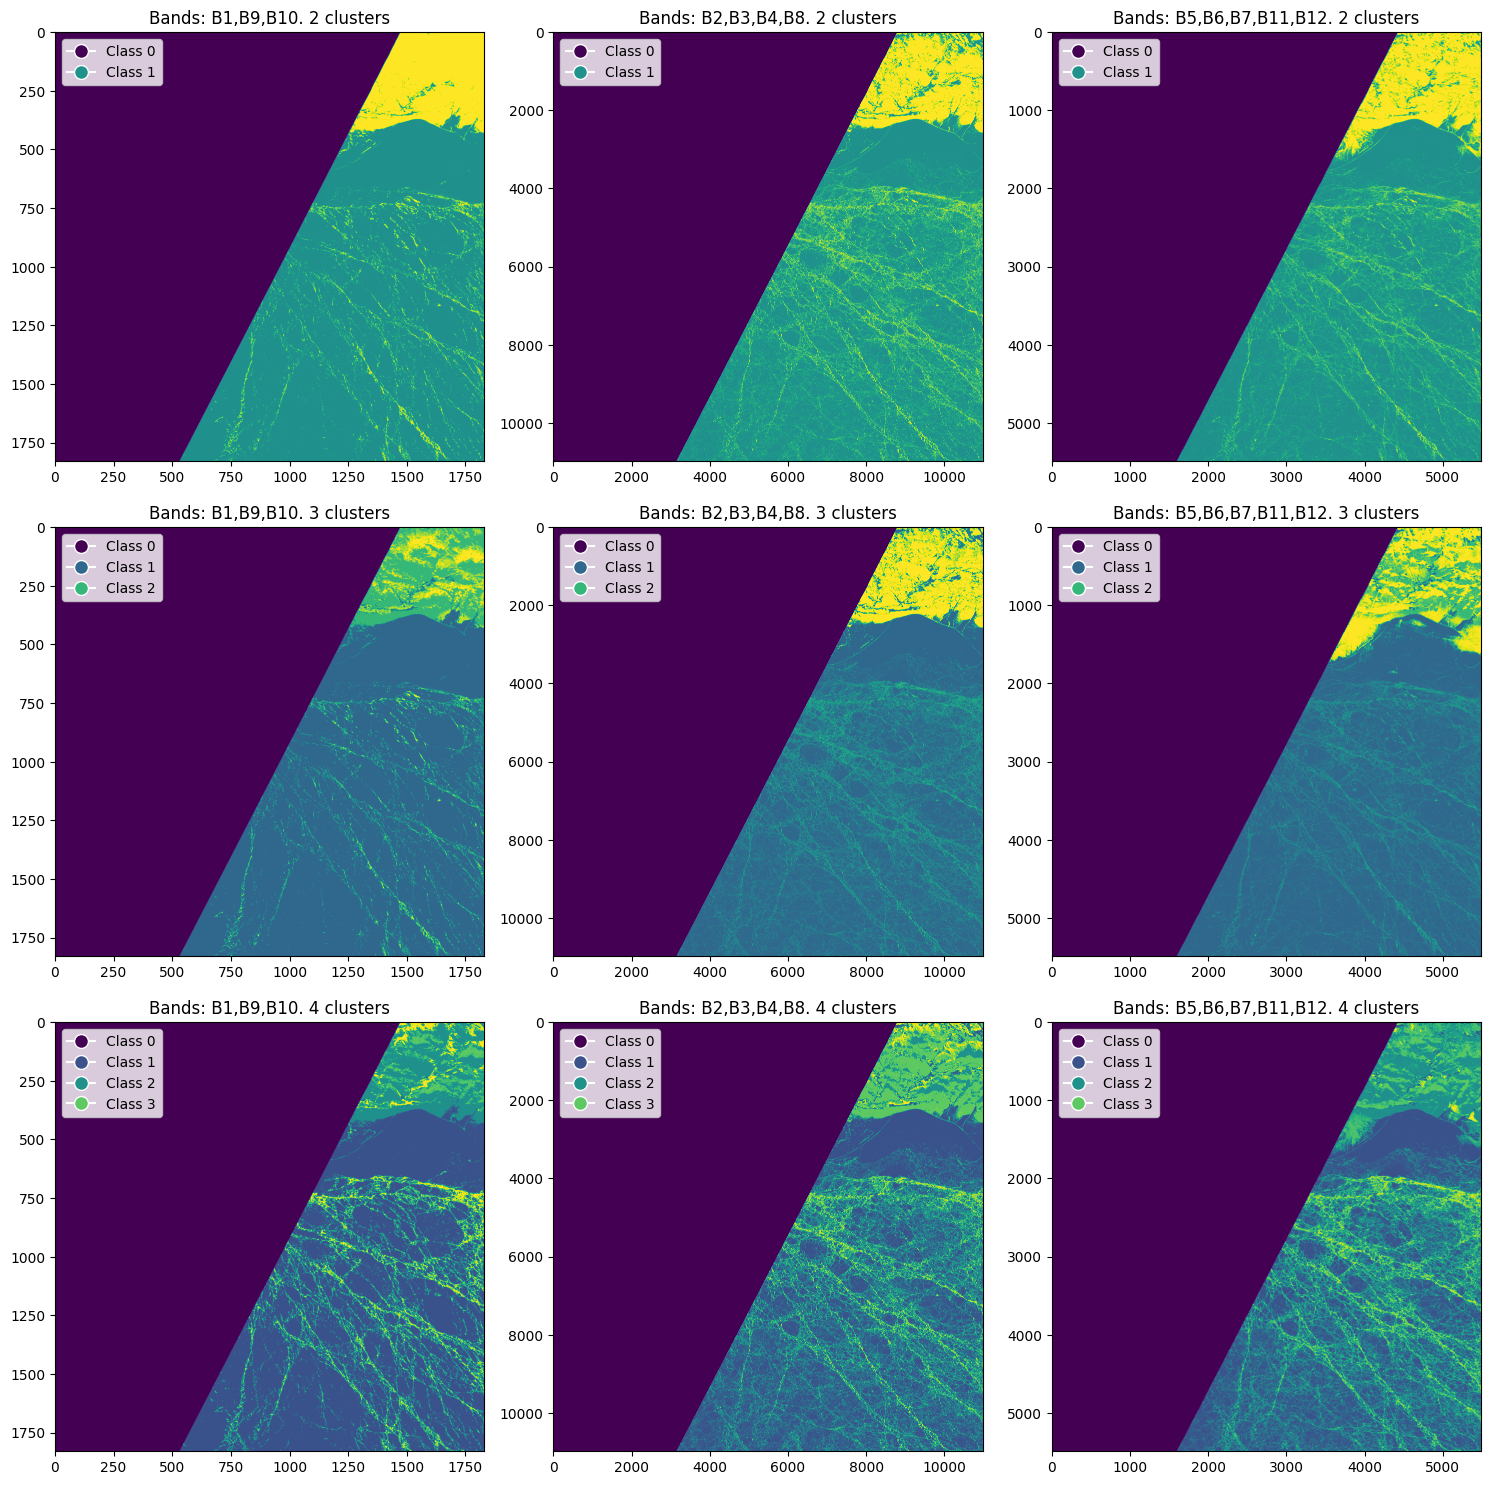

In [12]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

gmm_class_counts_dict = {}
# K-means clustering
for row, (shape, bands_to_include) in enumerate(same_shape_bands.items()):
    print(f"Bands: {','.join(bands_to_include)}")
    class_counts_shape = {}
    X_S2_all = np.hstack([X_S2_dict[band] for band in bands_to_include])
    band_stack_S2 = np.dstack([band_data_S2_dict[band] for band in bands_to_include])
    valid_data_mask = valid_data_mask_dict[shape]
    labels_image = np.full(band_stack_S2.shape[:2], -1, dtype=int)
    for k in range(0, 3):
        print(f"\t{k+2} clusters:")
        class_counts_k = {}
        gmm = GaussianMixture(n_components=k+2, random_state=0, max_iter=10).fit(X_S2_all)
        labels = gmm.predict(X_S2_all)
        labels_image[valid_data_mask] = labels
        im = axs[k][row].imshow(labels_image, cmap='viridis')
        axs[k][row].set_title(f"Bands: {','.join(bands_to_include)}. {str(k+2)} clusters")
        # Create a legend for the classes
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.viridis(i / (k+2)), markersize=10) for i in range(k+2)]
        labels = [f'Class {i}' for i in range(k+2)]
        axs[k][row].legend(handles, labels, loc='upper left')

        unique, counts = np.unique(labels, return_counts=True)
        class_counts = dict(zip(unique, counts))
        for key, val in class_counts.items():
            class_counts_k[key] = val
        class_counts_shape[k] = class_counts_k
    gmm_class_counts_dict[shape] = class_counts_shape

plt.tight_layout()
plt.savefig("Results/GMM_combined_bands_results.png")
plt.show()

### GMM: Radar Echo

#### Cluster altimetry data with 2, 3, 4 and 5 clusters


Cluster counts with 2 clusters:
	Cluster 0: 8880
	Cluster 1: 3315

Cluster counts with 3 clusters:
	Cluster 0: 3596
	Cluster 1: 3194
	Cluster 2: 5405


/opt/homebrew/Caskroom/miniforge/base/envs/GEOL0069-w4/lib/python3.9/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(



Cluster counts with 4 clusters:
	Cluster 0: 4275
	Cluster 1: 1946
	Cluster 2: 4569
	Cluster 3: 1405

Cluster counts with 5 clusters:
	Cluster 0: 4272
	Cluster 1: 1297
	Cluster 2: 4582
	Cluster 3: 1158
	Cluster 4: 886


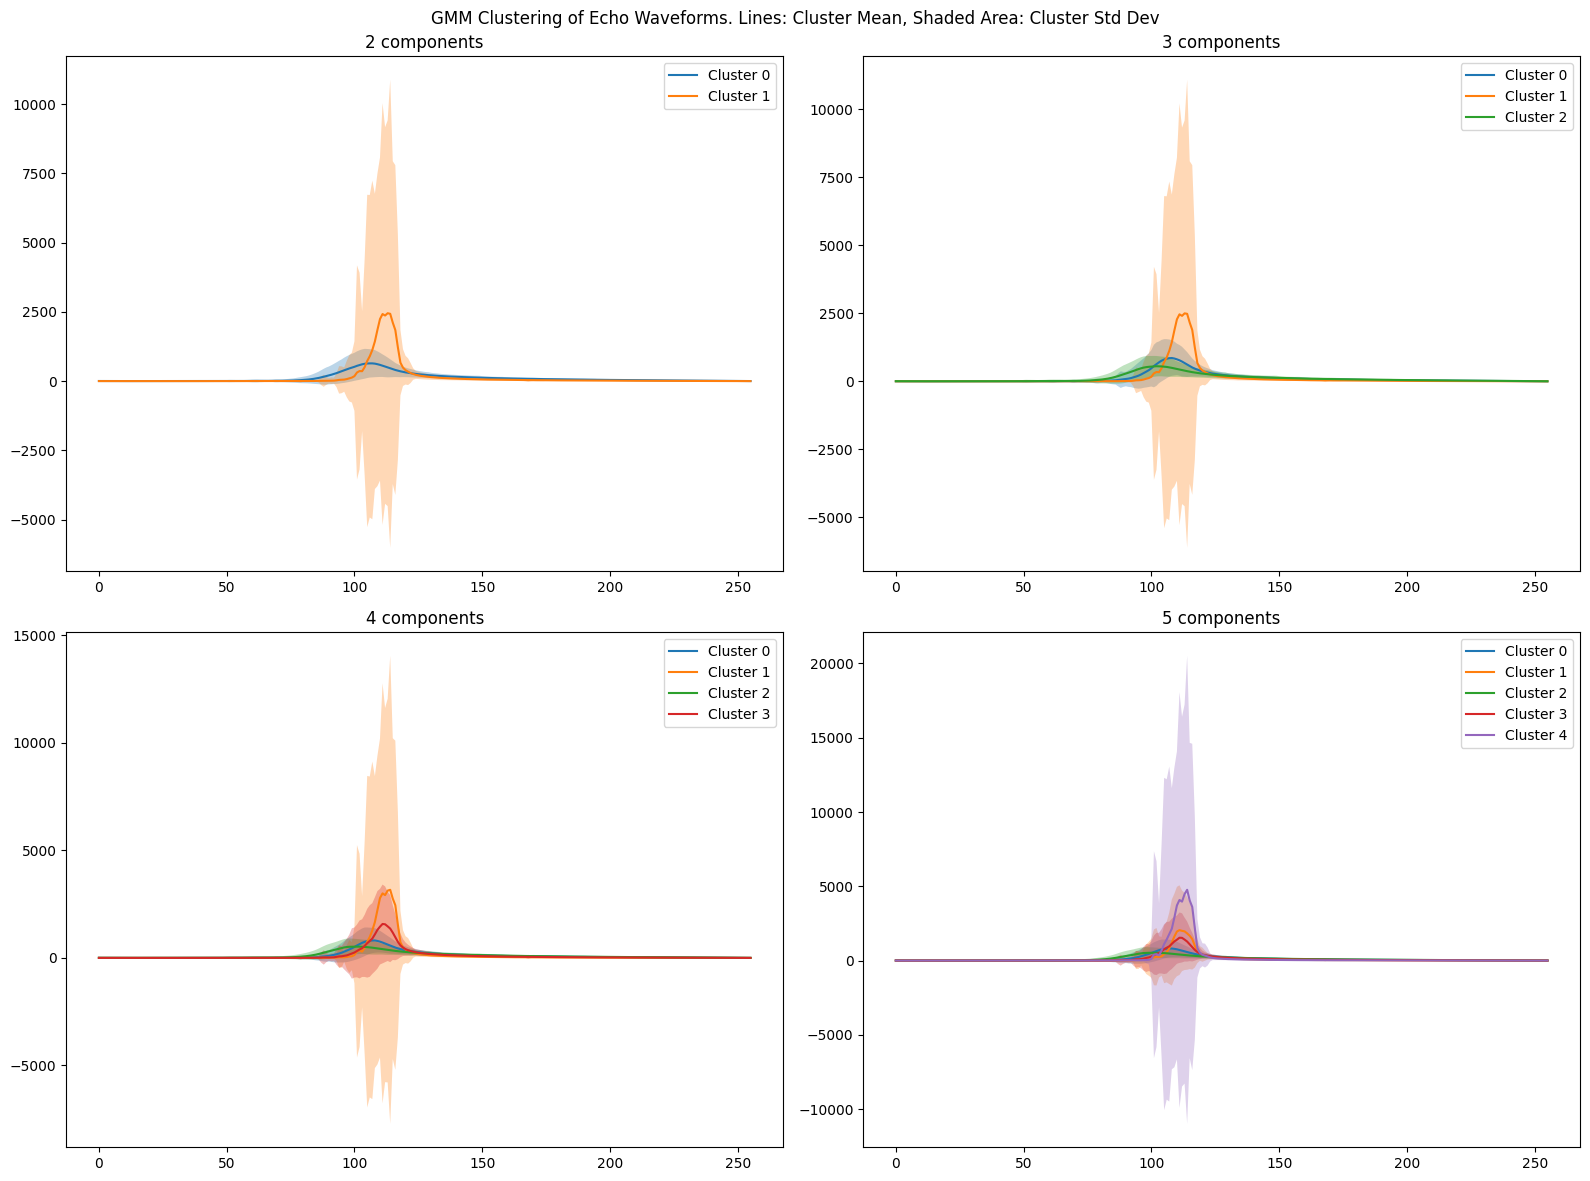

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
gmm_echo_labels = {}

for k in range(0, 4):
    gmm = GaussianMixture(n_components=k+2, random_state=0, max_iter=10).fit(SAR_data_cleaned)
    labels = gmm.predict(SAR_data_cleaned)
    gmm_echo_labels[k] = labels
    
    unique, counts = np.unique(labels, return_counts=True)
    class_counts = dict(zip(unique, counts))
    print(f"\nCluster counts with {k+2} clusters:")
    for key, val in class_counts.items():
        print(f"\tCluster {key}: {val}")
        cluster_mean = np.mean(waves_cleaned[labels==key], axis=0)
        cluster_std = np.std(waves_cleaned[labels==key], axis=0)
        axs[k//2][k%2].plot(cluster_mean, label=f'Cluster {key}')
        axs[k//2][k%2].fill_between(range(len(cluster_mean)), cluster_mean - cluster_std, cluster_mean + cluster_std, alpha=0.3)
    axs[k//2][k%2].set_title(f"{str(k+2)} components")
    axs[k//2][k%2].legend(loc='upper right')

fig.suptitle("GMM Clustering of Echo Waveforms. Lines: Cluster Mean, Shaded Area: Cluster Std Dev")
plt.tight_layout()
plt.savefig("Results/GMM_results_echo.png")
plt.show()

In [14]:
gmm = GaussianMixture(n_components=2, random_state=0)
gmm.fit(SAR_data_cleaned)
clusters_gmm = gmm.predict(SAR_data_cleaned)

unique, counts = np.unique(clusters_gmm, return_counts=True)
class_counts = dict(zip(unique, counts))
print("Cluster counts:", class_counts)

Cluster counts: {np.int64(0): np.int64(8880), np.int64(1): np.int64(3315)}


#### Plot cluster distributions in terms of PP, SSD and sig_0.

SSD is stack standard deviation, PP represents pulse peakiness, sig_0 amplitude.

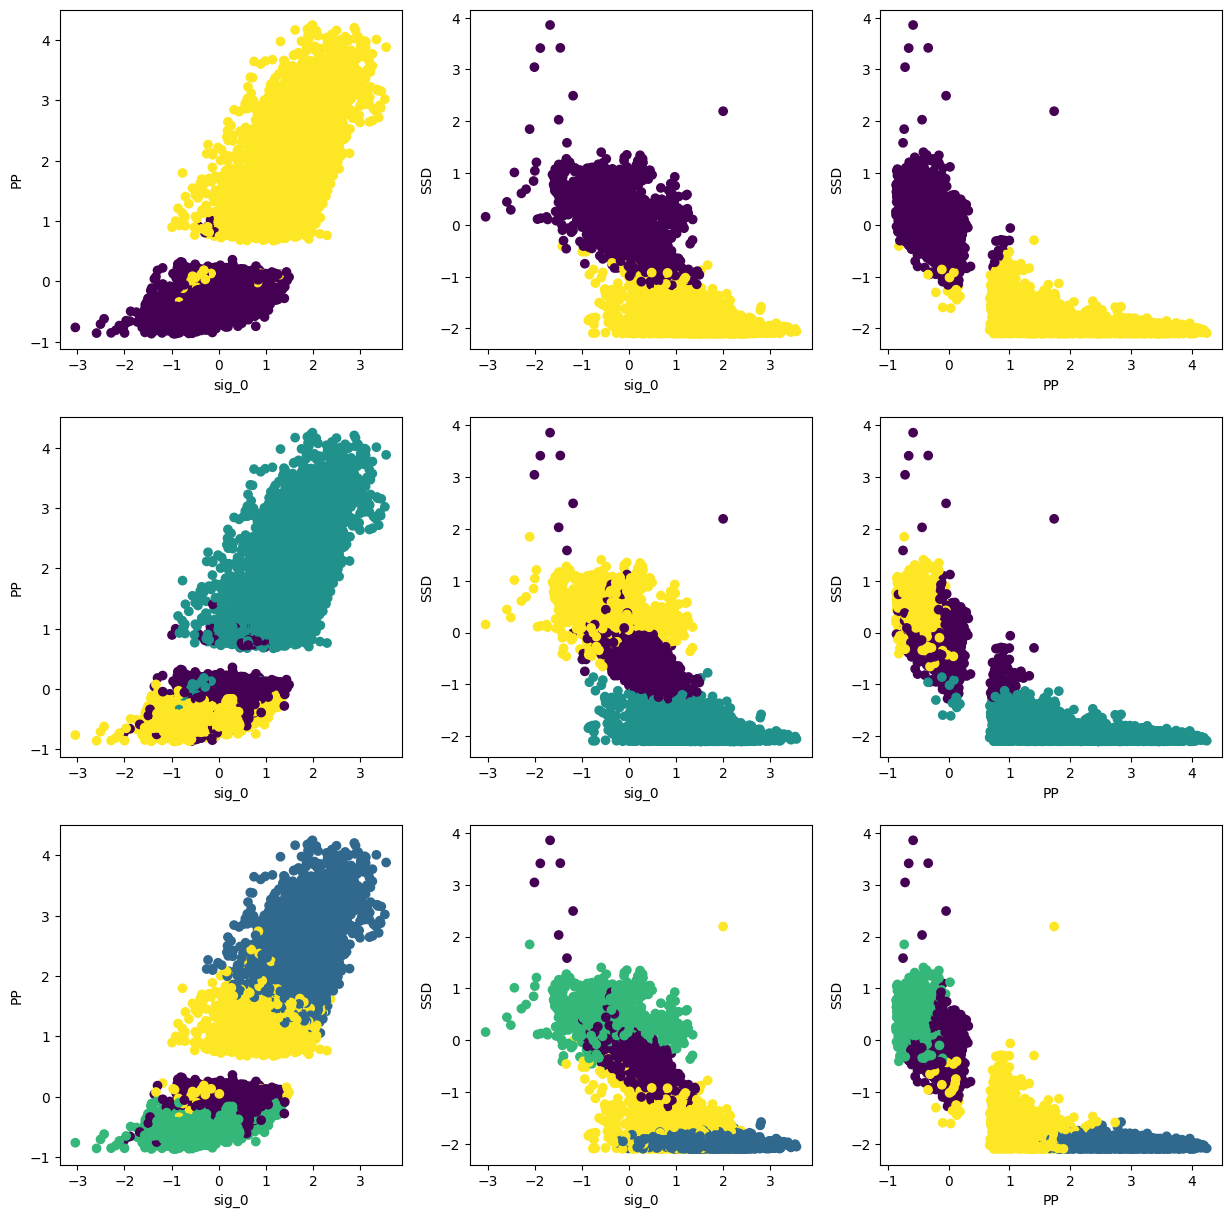

In [15]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

for k, cluster_labels in gmm_echo_labels.items():
    axs[k][0].scatter(SAR_data_cleaned[:,0],SAR_data_cleaned[:,1],c=cluster_labels)
    axs[k][0].set_xlabel("sig_0")
    axs[k][0].set_ylabel("PP")

    axs[k][1].scatter(SAR_data_cleaned[:,0],SAR_data_cleaned[:,2],c=cluster_labels)
    axs[k][1].set_xlabel("sig_0")
    axs[k][1].set_ylabel("SSD")

    axs[k][2].scatter(SAR_data_cleaned[:,1],SAR_data_cleaned[:,2],c=cluster_labels)
    axs[k][2].set_xlabel("PP")
    axs[k][2].set_ylabel("SSD")
    if k==2:
        break

plt.show()

In [16]:
true_labels = flag_cleaned - 1   # true labels from the ESA dataset
predicted_gmm = gmm_echo_labels[0]          # predicted labels from GMM method

# Compute confusion matrix
tn, fp, fn, tp = confusion_matrix(true_labels, predicted_gmm).ravel()

print("TWO CLUSTERS")

# Print confusion matrix
print("Confusion Matrix:")

print("\t\t| Predicted Negative  |  Predicted Positive")
print("----------------|---------------------|---------------------")
print(f"True Negative\t|\t {tn}\t      |  \t {fp}")
print("----------------|---------------------|---------------------")
print(f"True Positive\t|\t {fn}\t      |  \t{tp}")
print("----------------|---------------------|---------------------")

# Compute classification report
class_report = classification_report(true_labels, predicted_gmm)

# Print classification report
print("\nClassification Report:")
print(class_report)


true_labels = flag_cleaned - 1   # true labels from the ESA dataset
predicted_gmm = gmm_echo_labels[1]          # predicted labels from GMM method
predicted_gmm = np.where(predicted_gmm == 2, 0, predicted_gmm)

# Compute confusion matrix
tn, fp, fn, tp = confusion_matrix(true_labels, predicted_gmm).ravel()


print("\n\nTHREE CLUSTERS\nNote that two clusters have been grouped into one for validation.")
# Print confusion matrix
print("Confusion Matrix:")

print("\t\t| Predicted Negative  |  Predicted Positive")
print("----------------|---------------------|---------------------")
print(f"True Negative\t|\t {tn}\t      |  \t {fp}")
print("----------------|---------------------|---------------------")
print(f"True Positive\t|\t {fn}\t      |  \t{tp}")
print("----------------|---------------------|---------------------")

# Compute classification report
class_report = classification_report(true_labels, predicted_gmm)

# Print classification report
print("\nClassification Report:")
print(class_report)

TWO CLUSTERS
Confusion Matrix:
		| Predicted Negative  |  Predicted Positive
----------------|---------------------|---------------------
True Negative	|	 8856	      |  	 22
----------------|---------------------|---------------------
True Positive	|	 24	      |  	3293
----------------|---------------------|---------------------

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      8878
         1.0       0.99      0.99      0.99      3317

    accuracy                           1.00     12195
   macro avg       1.00      1.00      1.00     12195
weighted avg       1.00      1.00      1.00     12195



THREE CLUSTERS
Note that two clusters have been grouped into one for validation.
Confusion Matrix:
		| Predicted Negative  |  Predicted Positive
----------------|---------------------|---------------------
True Negative	|	 8865	      |  	 13
----------------|---------------------|---------------------
True Positive

## Concluding comments

### Clustering Optical Satellite Images
The mountains in the upper right courner of the images clearly inhibited the performance of the clustering algorithms. Both GMM and K-Means managed to distinguish leads from sea ice when the number of clusters were set to 4 or 5 (one of the clusters was "used" for the awkard left triangle of the images, so it should in fact be considered 3 or 4 clusters). It is likely that 3 (2) clusters would have been sufficient if there were no mountains in the image (and if the image was complete).

Clustering complitations of bands did not seem to improve the results from just using band 9, yet this is hard to asses without true labels.

### Clustering Altimetry Data
For GMM clustering of altimetry data, it seems like using three cluster performed worse than two clusters. This is supported by the cluster distributions visualized by scatter plots.